# Combining our Datasets

This notebook is meant to show some basic EDA around marrying our two primary commuting datasets together, the Hub Bound Data (HBD) and the IPUMS data. In this notebook we'll look at the differences in estimated commuters, compare mode share and look at what modes of transit appear in each dataset.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# read in hbd data
hbd_df = pd.read_csv("est_commuters_HBD.csv",index_col=0)
hbd_df.sample(5)

,Sector,PointEntryExit,TransMode,Direction,Hour,Estimated_Commuters
691,60thSt,2ndAve,Bus,In,19,304
3869,Brooklyn,WilliamsburgBridge,Subway,In,5,1888
2605,60thSt,ParkAve,Bicycle,Out,13,64
1010,60thSt,6thAve,Autos,Out,2,0
2395,60thSt,MadisonAve,Autos,Out,19,1001


In [3]:
### All of the IPUMS tables have TransMode and Hour, so we can just grab any
### Grabbing PUMA origin table just for illustrative purposes.
### We are only interested in counts byy hour and transmode here
commuter_origin_df = pd.read_csv("ipums_data_drop/commuter_origin_counts.csv",index_col=0)
### We only need 2019
commuter_origin_df=commuter_origin_df[commuter_origin_df['YEAR']==2019]
commuter_origin_df.head(2)

,YEAR,TransMode,Hour,PUMA,STATEFIP,PUMA_NAME,Estimated_Commuters
8775,2019,AutoOccupants,0,100,9,"Danbury, Ridgefield, Bethel, Brookfield, New F...",69.0
8776,2019,AutoOccupants,0,305,34,"Bergen County (East)--Tenafly, Park Ridge & Cr...",82.0


In [4]:
commuter_origin_df["Estimated_Commuters"].sum()

# IPUMS - Total Commuters In by mode of Transit
commuter_origin_df.groupby(by=["TransMode"]).agg({"Estimated_Commuters":"sum"})

,Estimated_Commuters
TransMode,
AutoOccupants,328247.0
Bicycle,28821.0
Bus,296874.0
CommuterRail,333024.0
Ferry,27611.0
Other,10699.0
Subway,1367781.0
WFH,70151.0
Walk,208426.0


In [5]:
## Aggregate data sources by TransMode + Hour for joining
gb_tranmode_hr_acs = commuter_origin_df.groupby(by=["TransMode","Hour"]).agg({"Estimated_Commuters":"sum"}).reset_index()
gb_tranmode_hr_hbd = hbd_df.groupby(by=["TransMode","Hour"]).agg({"Estimated_Commuters":"sum"}).reset_index()


In [6]:
#### Merge them together
check_df = pd.merge(left=gb_tranmode_hr_acs,right=gb_tranmode_hr_hbd\
                   ,on=["TransMode","Hour"],suffixes=("_ipums",'_hbd'),how='outer')
check_df['Estimated_Commuters_Pct'] = check_df['Estimated_Commuters_ipums']/check_df['Estimated_Commuters_hbd']
check_df['Estimated_Commuters_IPUMS_Minus_HBD'] = check_df['Estimated_Commuters_ipums']-check_df['Estimated_Commuters_hbd']
check_df.head(5)

,TransMode,Hour,Estimated_Commuters_ipums,Estimated_Commuters_hbd,Estimated_Commuters_Pct,Estimated_Commuters_IPUMS_Minus_HBD
0,AutoOccupants,0,2526.0,50241.0,0.050278,-47715.0
1,AutoOccupants,1,1015.0,32032.0,0.031687,-31017.0
2,AutoOccupants,2,740.0,22598.0,0.032746,-21858.0
3,AutoOccupants,3,2021.0,21405.0,0.094417,-19384.0
4,AutoOccupants,4,4560.0,29815.0,0.152943,-25255.0


In [7]:
## Both datasets have slightly different modes of transportation. Any like items have been joined in the
## data cleaning process. But there are a few others that are not in both. We'll exclude those for visualizations
print("Missing any hours in IPUMS",check_df[check_df['Estimated_Commuters_ipums'].isna()]['TransMode'].unique())
print("Missing any hours in HBD",check_df[check_df['Estimated_Commuters_hbd'].isna()]['TransMode'].unique())
tm_in_both = check_df[~(check_df['Estimated_Commuters_ipums'].isna())&\
        ~(check_df['Estimated_Commuters_hbd'].isna())]['TransMode'].unique()

print("In Both: ", tm_in_both)

## Autos, Bicycle, Ferry + Tram all are missing hours in the IPUMS data - there are some hours withour bicycle
## but the rest are just not in IPUMS

## Other, WFH and Walk are not in the HBD for obvious reasons. You can't measure "Other" or "WFH" and the data
## doesn't catch any walkers either into the CBD or already in the CBD.

Missing any hours in IPUMS ['Autos' 'Bicycle' 'Ferry' 'Tram']
Missing any hours in HBD ['Other' 'WFH' 'Walk']
In Both:  ['AutoOccupants' 'Bicycle' 'Bus' 'CommuterRail' 'Ferry' 'Subway']


In [8]:
check_df[check_df['TransMode'].isin(tm_in_both)][["Estimated_Commuters_hbd","Estimated_Commuters_ipums"]].sum()

## These numbers are different - ipums only has commutes in and
## not all trips into the CBD are commutes, as well. Less than half makes sense

Estimated_Commuters_hbd      7656270.0
Estimated_Commuters_ipums    2382358.0
dtype: float64

### Visualizing some differences

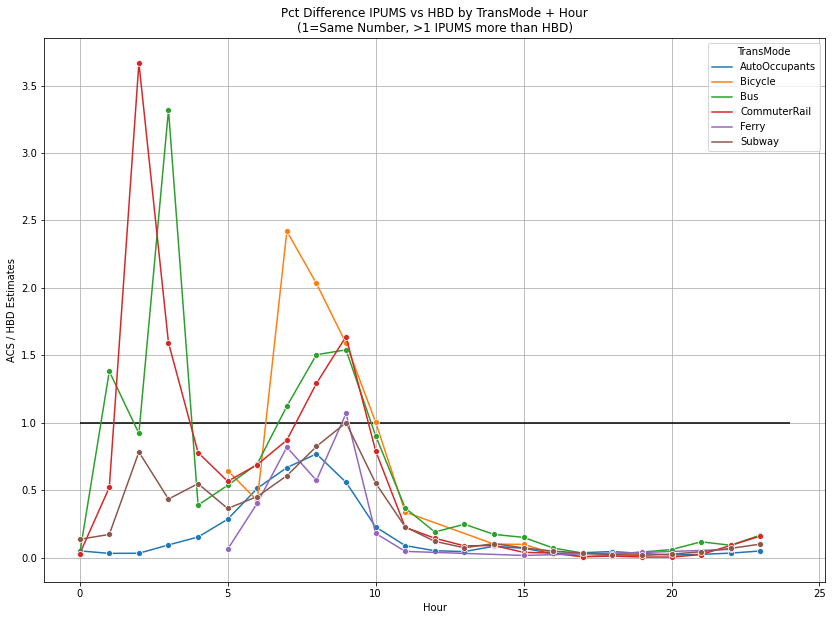

In [9]:
### What's the difference by TransMode and Hour?
## First, looking at it as a percentage of the HBD data

fig,ax=plt.subplots(figsize=(14,10))
plt.grid()
sns.lineplot(data=check_df[check_df['TransMode'].isin(tm_in_both)]\
             ,x='Hour',y='Estimated_Commuters_Pct',marker='o',hue='TransMode',ax=ax)
ax.hlines(y=1,xmin=0,xmax=24,color='black')
ax.set_ylabel("ACS / HBD Estimates")
ax.set_title("Pct Difference IPUMS vs HBD by TransMode + Hour\n(1=Same Number, >1 IPUMS more than HBD)");



For many of the morning hours, the IPUMS data has higher counts in modes such as commuter rail, bus, and bicycle. However, as we'll see below, these are not massive gross differences.

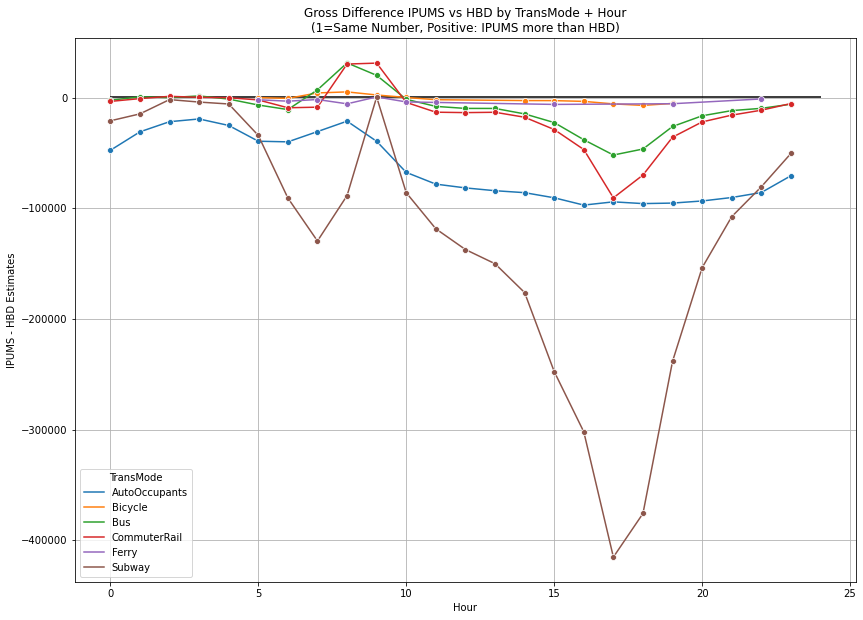

In [10]:
## Next, looking at it as a gross difference - subtraction
fig,ax=plt.subplots(figsize=(14,10))
plt.grid()
sns.lineplot(data=check_df[check_df['TransMode'].isin(tm_in_both)]\
             ,x='Hour',marker='o',y='Estimated_Commuters_IPUMS_Minus_HBD',hue='TransMode',ax=ax)
ax.hlines(y=1,xmin=0,xmax=24,color='black')
ax.set_ylabel("IPUMS - HBD Estimates")
ax.set_title("Gross Difference IPUMS vs HBD by TransMode + Hour\n(1=Same Number, Positive: IPUMS more than HBD)");



Now we can see that the differences in the morning are actually not as massive as the first graph would show - for most of the morning, each hour and transit mode are within (a relatively small) 100K of each other. Obviously these differences grow in the afternoon, where we do not have any commute home counts from IPUMS (yet - we can extrapolate those later).

/var/folders/19/p4qfz4hx08v34206x9tr10000000gn/T/ipykernel_45646/2172545373.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mode_share_df.groupby(by=["Hour"])["PctHour_IPUMS",'PctHour_HBD'].sum() #looks good


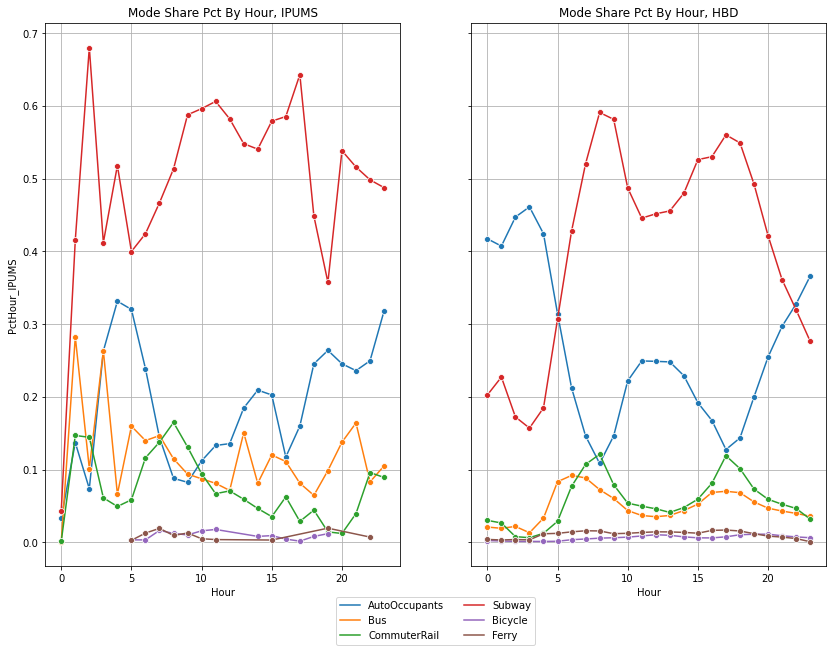

In [11]:
## Look at each dataset's modal split by hour
totals_by_hour = check_df.groupby(by=["Hour"]).agg({"Estimated_Commuters_ipums":"sum","Estimated_Commuters_hbd":"sum"})
totals_by_hour.columns = ['total_hourly_ipums','total_hourly_hbd']
totals_by_hour.reset_index(inplace=True)
mode_share_df = check_df.merge(totals_by_hour,on=['Hour'])
mode_share_df['PctHour_IPUMS'] = mode_share_df['Estimated_Commuters_ipums']/mode_share_df['total_hourly_ipums']
mode_share_df['PctHour_HBD'] = mode_share_df['Estimated_Commuters_hbd']/mode_share_df['total_hourly_hbd']


mode_share_df[["Hour",'TransMode',"PctHour_IPUMS",'PctHour_HBD']]


# Check
mode_share_df.groupby(by=["Hour"])["PctHour_IPUMS",'PctHour_HBD'].sum() #looks good

graph_mode_share_df = mode_share_df[mode_share_df['TransMode'].isin(tm_in_both)]\
[["Hour",'TransMode',"PctHour_IPUMS",'PctHour_HBD']].copy()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,10),sharey=True)
ax1.grid(True),ax2.grid(True)
sns.lineplot(data=graph_mode_share_df\
             ,x='Hour',marker='o',y='PctHour_IPUMS',hue='TransMode',ax=ax1)
ax1.set_title("Mode Share Pct By Hour, IPUMS")
sns.lineplot(data=graph_mode_share_df\
             ,x='Hour',marker='o',y='PctHour_HBD',hue='TransMode',ax=ax2)
ax2.set_title("Mode Share Pct By Hour, HBD");

leg1 = ax1.legend(loc='center', bbox_to_anchor=(1.1, -0.10), shadow=False, ncol=2)
leg2 = ax2.legend(loc='center', bbox_to_anchor=(1.1, -0.10), shadow=False, ncol=2)
leg2.remove()



Mode splits by hour actually look fairly similar. Subway is almost always the top mode, though there are slightly more cars driving into the CBD in the very early morning hours, according to the HBD. And autos are a clear second, with splits decreasing in the heaviest commuting in/out hours and highest on the starts and ends of the day.

Commuter Rail and Bus follow similar patterns, peaking at approximately 10% in HBD and 25% in IPUMS, but similarly peaking around commuting times and dropping slightly at midday and end of day.

Bicycle and Ferry are consistently at the bottom with <5% of mode split throughought the day.